In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps

Here's some text about what we need to do.

### Import data from BigQuery

In [4]:
sql = """
  -- first, we create a temp table with aggregated data for each bnf_code and month,
  -- which signfic antly reduces runtime for the main query
  -- first, we create a temp table with aggregated data for each bnf_code and month,
  -- which signficantly reduces runtime for the main query
  CREATE TEMP TABLE price_concessions_quantity AS
SELECT
  month,
  rx.bnf_code AS bnf_code,
  RTRIM(bnf_name) AS bnf_name,
  SUM(quantity) AS quantity,
  SUM(actual_cost) AS actual_cost,
  AVG(SUM(quantity)) OVER (PARTITION BY rx.bnf_code ORDER BY month ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS rolling_ave_quantity -- this creates a 3 month rolling average of quantity
FROM
  hscic.normalised_prescribing_standard AS rx
INNER JOIN (
  SELECT
    bnf_code
  FROM
    dmd.ncsoconcession AS ncso
  INNER JOIN
    dmd.vmpp AS vmpp
  ON
    vmpp.id=ncso.vmpp
  GROUP BY
    bnf_code) AS ncso
ON
  ncso.bnf_code = rx.bnf_code
GROUP BY
  month,
  rx.bnf_code,
  bnf_name
ORDER BY
  bnf_code,
  month ;
  --this is the main query
SELECT
  rx.month AS rx_month,
  vmpp.bnf_code AS bnf_code,
  vmpp.nm AS product_name,
  SUM(rx.quantity) AS quantity,
  SUM(rx.rolling_ave_quantity) AS rolling_ave_quantity,
  dt.price_pence AS dt_price_pence,
  ncso.price_pence AS ncso_price_pence,
  SUM((dt.price_pence * rx_item.quantity *
      CASE WHEN
      -- This uses quantity from 2 months prior to the prescribing month.
      -- This is the data available at the time of the price concession announcement,
      -- so we use this to predict.
      -- For some presentations "quantity" means "number of packs" rather
      -- than e.g. tablets. In these cases we don't want to divide by the
      -- quantity value of a pack. This is implemented via a flag in our
      -- databse but this data isn't in BiqQuery so we just have a hardcoded
      -- list of BNF codes here
      vmpp.bnf_code IN ('0206010F0AACJCJ', '1202010U0AAAAAA') THEN 1
      ELSE
      1 / vmpp.qtyval
    END
      -- This is the "discount factor" which applies the National Average 7.2%
      -- discount to estimate Actual Cost from Net Ingredient Cost and also
      -- converts figures from pence to pounds
      * 0.00928)+ (COALESCE(ncso.price_pence - dt.price_pence,
        0) * rx_item.quantity *
      CASE
        WHEN vmpp.bnf_code IN ('0206010F0AACJCJ', '1202010U0AAAAAA') THEN 1
      ELSE
      1 / vmpp.qtyval
    END
      * 0.00928)) AS predicted_cost,
  SUM((dt.price_pence * rx_item.rolling_ave_quantity * -- this is using 3 months rolling quantity average
      CASE
        WHEN vmpp.bnf_code IN ('0206010F0AACJCJ', '1202010U0AAAAAA') THEN 1
      ELSE
      1 / vmpp.qtyval
    END
      * 0.00928)+ (COALESCE(ncso.price_pence - dt.price_pence,
        0) * rx_item.rolling_ave_quantity *
      CASE
        WHEN vmpp.bnf_code IN ('0206010F0AACJCJ', '1202010U0AAAAAA') THEN 1
      ELSE
      1 / vmpp.qtyval
    END
      * 0.00928)) AS predicted_cost_rolling,
  SUM(rx.actual_cost) AS actual_cost
FROM
  dmd.tariffprice AS dt
RIGHT JOIN
  dmd.ncsoconcession AS ncso
ON
  ncso.vmpp = dt.vmpp
  AND ncso.date = dt.date
INNER JOIN
  dmd.vmpp AS vmpp
ON
  vmpp.id=ncso.vmpp
INNER JOIN
  price_concessions_quantity AS rx --this is joining to the temp table, creating the current month actual_cost
ON
  rx.bnf_code = vmpp.bnf_code
  AND rx.month = TIMESTAMP(ncso.date)
INNER JOIN
  price_concessions_quantity AS rx_item --this is joining to the temp table, with a 2 month difference to calculate predicted quantities
ON
  rx_item.bnf_code = vmpp.bnf_code
  AND rx_item.month = TIMESTAMP(DATE_ADD(ncso.date, INTERVAL -2 month))
WHERE
  rx.month >='2017-01-01'
GROUP BY
  rx.month,
  vmpp.bnf_code,
  vmpp.nm,
  dt.price_pence,
  ncso.price_pence,
  TIMESTAMP(DATE_ADD(ncso.date, INTERVAL -2 month))
ORDER BY
  vmpp.bnf_code,
  rx.month
"""

#exportfile = os.path.join("..","data","ncso_df.csv")
ncso_df = bq.cached_read(sql, csv_path='data/ncso_df.csv')
ncso_df["predicted_cost"] = pd.to_numeric(ncso_df["predicted_cost"])

Downloading: 100%|██████████| 2040/2040 [00:00<00:00, 3257.85rows/s]


In [5]:
ncso_sum_df=ncso_df.groupby('rx_month')[['quantity','rolling_ave_quantity','predicted_cost','predicted_cost_rolling','actual_cost']].sum()  #group data to show total per month

In [6]:
ncso_sum_df['difference'] = ncso_sum_df['predicted_cost'] - ncso_sum_df['actual_cost']  #calculate difference between predicted and actual

In [7]:
ncso_sum_df['perc_difference'] = ncso_sum_df['difference'] / ncso_sum_df['actual_cost'] #calculate percentage difference

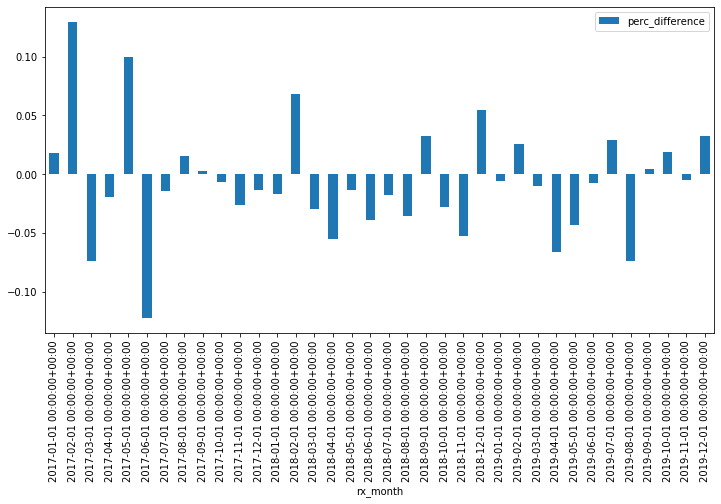

In [8]:
ax = ncso_sum_df.plot.bar(figsize = (12,6), y='perc_difference')

In [9]:
ncso_sum_df['difference_rolling'] = ncso_sum_df['predicted_cost_rolling'] - ncso_sum_df['actual_cost']  #calculate difference between 3 month average rolling predicted and actual

In [10]:
ncso_sum_df['perc_difference_rolling'] = ncso_sum_df['difference_rolling'] / ncso_sum_df['actual_cost'] #calculate percentage difference on 3 month rolling

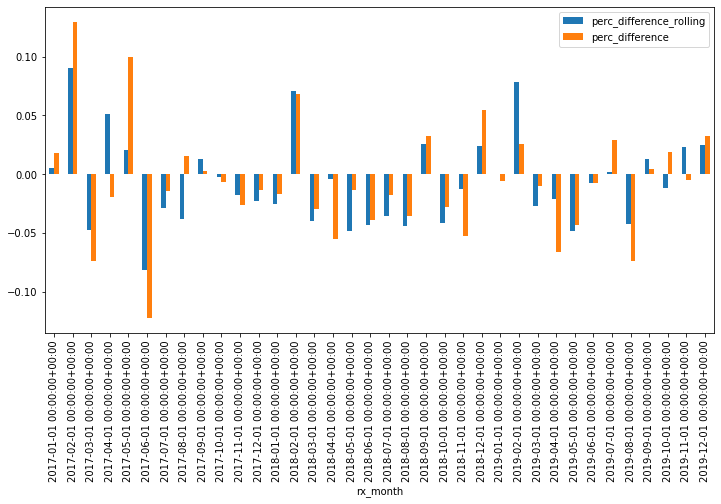

In [11]:
ax = ncso_sum_df.plot.bar(figsize = (12,6), y=['perc_difference_rolling', 'perc_difference'])

### How could we get more accuracy?

In [ ]:
# import bank holidays json (2012-2020)
#from pandas.io.json import json_normalize #package for flattening json in pandas df

In [16]:
# load bank holidays json and pass to busdays function `holidays=[]` ###
url = 'https://www.gov.uk/bank-holidays.json'
bh = pd.read_json(url, orient='index')
# separate out the embedded json 
#flattening json in pandas df
bh2 = pd.json_normalize(bh.iloc[0]["events"])
bh2.head()

,title,date,notes,bunting
0,New Year’s Day,2015-01-01,,True
1,Good Friday,2015-04-03,,False
2,Easter Monday,2015-04-06,,True
3,Early May bank holiday,2015-05-04,,True
4,Spring bank holiday,2015-05-25,,True


In [17]:
ncso_dates_df=ncso_sum_df.reset_index()

In [18]:
import calendar
dates = ncso_dates_df[["rx_month"]].drop_duplicates()
dates["rx_month"] = pd.to_datetime(dates["rx_month"])
dates["year"] = dates["rx_month"].dt.year
dates["mon"] = dates["rx_month"].dt.month
d = []
for row in dates.itertuples():
    y = row.year
    m = row.mon
    day = calendar.monthrange(y,m)[1]
    d.append(str(y)+"-"+str(m)+"-"+str(day))
d = pd.Series(d, name="enddates")
d = pd.to_datetime(d, format="%Y/%m/%d")
begindates = pd.Series(dates["rx_month"]).values.astype('datetime64[D]')
enddates = pd.Series(d).values.astype('datetime64[D]')
#######
# find business days in month
dates["bdays0"] = np.busday_count(begindates, enddates) # not excluding bank holidays
dates["bdays"] = np.busday_count(begindates, enddates, holidays=bh2["date"].values.astype('datetime64[D]'))
dates.head()

,rx_month,year,mon,bdays0,bdays
0,2017-01-01 00:00:00+00:00,2017,1,21,20
1,2017-02-01 00:00:00+00:00,2017,2,19,19
2,2017-03-01 00:00:00+00:00,2017,3,22,22
3,2017-04-01 00:00:00+00:00,2017,4,20,18
4,2017-05-01 00:00:00+00:00,2017,5,22,20


In [19]:
dates.set_index('rx_month')

,year,mon,bdays0,bdays
rx_month,,,,
2017-01-01 00:00:00+00:00,2017,1,21,20
2017-02-01 00:00:00+00:00,2017,2,19,19
2017-03-01 00:00:00+00:00,2017,3,22,22
2017-04-01 00:00:00+00:00,2017,4,20,18
2017-05-01 00:00:00+00:00,2017,5,22,20
2017-06-01 00:00:00+00:00,2017,6,21,21
2017-07-01 00:00:00+00:00,2017,7,20,20
2017-08-01 00:00:00+00:00,2017,8,22,21
2017-09-01 00:00:00+00:00,2017,9,21,21


In [20]:
ncso_sum_df.reset_index()

,rx_month,quantity,rolling_ave_quantity,predicted_cost,predicted_cost_rolling,actual_cost,difference,perc_difference,difference_rolling,perc_difference_rolling
0,2017-01-01 00:00:00+00:00,34903814,3.580363e+07,8.151401e+06,8.049272e+06,8.008703e+06,1.426981e+05,0.017818,4.056951e+04,0.005066
1,2017-02-01 00:00:00+00:00,32129651,3.424974e+07,8.397418e+06,8.104830e+06,7.433894e+06,9.635236e+05,0.129612,6.709353e+05,0.090254
2,2017-03-01 00:00:00+00:00,35701169,3.324040e+07,8.078590e+06,8.310292e+06,8.723591e+06,-6.450013e+05,-0.073938,-4.132996e+05,-0.047377
3,2017-04-01 00:00:00+00:00,31360938,3.252794e+07,6.176515e+06,6.621021e+06,6.300387e+06,-1.238728e+05,-0.019661,3.206338e+05,0.050891
4,2017-05-01 00:00:00+00:00,34668969,3.425155e+07,1.361543e+07,1.263800e+07,1.238387e+07,1.231558e+06,0.099449,2.541320e+05,0.020521
5,2017-06-01 00:00:00+00:00,39153931,3.693957e+07,2.858565e+07,2.993281e+07,3.257050e+07,-3.984846e+06,-0.122345,-2.637690e+06,-0.080984
6,2017-07-01 00:00:00+00:00,44127391,4.466837e+07,3.520778e+07,3.466878e+07,3.570354e+07,-4.957595e+05,-0.013885,-1.034757e+06,-0.028982
7,2017-08-01 00:00:00+00:00,109038306,1.071921e+08,4.732995e+07,4.481809e+07,4.659972e+07,7.302289e+05,0.015670,-1.781633e+06,-0.038233
8,2017-09-01 00:00:00+00:00,270715011,2.700915e+08,5.839371e+07,5.900726e+07,5.823806e+07,1.556503e+05,0.002673,7.691957e+05,0.013208
9,2017-10-01 00:00:00+00:00,403633528,4.001768e+08,7.105413e+07,7.138988e+07,7.154741e+07,-4.932872e+05,-0.006895,-1.575319e+05,-0.002202


In [21]:
ncso_sum_df.dtypes

quantity                     int64
rolling_ave_quantity       float64
predicted_cost             float64
predicted_cost_rolling     float64
actual_cost                float64
difference                 float64
perc_difference            float64
difference_rolling         float64
perc_difference_rolling    float64
dtype: object

In [22]:
result = pd.merge(ncso_sum_df, dates, on='rx_month')

In [23]:
result.dtypes

rx_month                   datetime64[ns, UTC]
quantity                                 int64
rolling_ave_quantity                   float64
predicted_cost                         float64
predicted_cost_rolling                 float64
actual_cost                            float64
difference                             float64
perc_difference                        float64
difference_rolling                     float64
perc_difference_rolling                float64
year                                     int64
mon                                      int64
bdays0                                   int64
bdays                                    int64
dtype: object

In [24]:
import calendar
dates = ncso_dates_df[["rx_month"]].drop_duplicates()
dates["rx_month"] = pd.to_datetime(dates["rx_month"])
dates["year"] = dates["rx_month"].dt.year
dates["mon"] = dates["rx_month"].dt.month
d = []
for row in dates.itertuples():
    y = row.year
    m = row.mon
    day = calendar.monthrange(y,m)[1]
    d.append(str(y)+"-"+str(m)+"-"+str(day))
d = pd.Series(d, name="enddates")
d = pd.to_datetime(d, format="%Y/%m/%d")
begindates = pd.Series(dates["rx_month"]).values.astype('datetime64[D]')
enddates = pd.Series(d).values.astype('datetime64[D]')
#######
# find business days in month
dates["bdays0"] = np.busday_count(begindates, enddates) # not excluding bank holidays
dates["bdays"] = np.busday_count(begindates, enddates, holidays=bh2["date"].values.astype('datetime64[D]'))
dates.head()

,rx_month,year,mon,bdays0,bdays
0,2017-01-01 00:00:00+00:00,2017,1,21,20
1,2017-02-01 00:00:00+00:00,2017,2,19,19
2,2017-03-01 00:00:00+00:00,2017,3,22,22
3,2017-04-01 00:00:00+00:00,2017,4,20,18
4,2017-05-01 00:00:00+00:00,2017,5,22,20


In [25]:
dates.set_index('rx_month')

,year,mon,bdays0,bdays
rx_month,,,,
2017-01-01 00:00:00+00:00,2017,1,21,20
2017-02-01 00:00:00+00:00,2017,2,19,19
2017-03-01 00:00:00+00:00,2017,3,22,22
2017-04-01 00:00:00+00:00,2017,4,20,18
2017-05-01 00:00:00+00:00,2017,5,22,20
2017-06-01 00:00:00+00:00,2017,6,21,21
2017-07-01 00:00:00+00:00,2017,7,20,20
2017-08-01 00:00:00+00:00,2017,8,22,21
2017-09-01 00:00:00+00:00,2017,9,21,21


In [26]:
dates.index = pd.to_datetime(dates.index)

In [27]:
#dates['pred_month'] = dates.lookup(dates.index, dates['bdays'])
result['bdays2']=result['bdays'].shift(2)

In [28]:
result.head()

,rx_month,quantity,rolling_ave_quantity,predicted_cost,predicted_cost_rolling,actual_cost,difference,perc_difference,difference_rolling,perc_difference_rolling,year,mon,bdays0,bdays,bdays2
0,2017-01-01 00:00:00+00:00,34903814,3.580363e+07,8.151401e+06,8.049272e+06,8.008703e+06,1.426981e+05,0.017818,40569.506133,0.005066,2017,1,21,20,NaN
1,2017-02-01 00:00:00+00:00,32129651,3.424974e+07,8.397418e+06,8.104830e+06,7.433894e+06,9.635236e+05,0.129612,670935.319094,0.090254,2017,2,19,19,NaN
2,2017-03-01 00:00:00+00:00,35701169,3.324040e+07,8.078590e+06,8.310292e+06,8.723591e+06,-6.450013e+05,-0.073938,-413299.571904,-0.047377,2017,3,22,22,20.0
3,2017-04-01 00:00:00+00:00,31360938,3.252794e+07,6.176515e+06,6.621021e+06,6.300387e+06,-1.238728e+05,-0.019661,320633.790940,0.050891,2017,4,20,18,19.0
4,2017-05-01 00:00:00+00:00,34668969,3.425155e+07,1.361543e+07,1.263800e+07,1.238387e+07,1.231558e+06,0.099449,254132.031249,0.020521,2017,5,22,20,22.0


In [29]:
result['predicted_cost_adj']=(result['bdays2']/result['bdays'])*result['predicted_cost']

In [30]:
result['difference_adj']=result['predicted_cost_adj']-result['actual_cost']

In [31]:
result['percent_difference_adj']=result['difference_adj']/result['actual_cost']

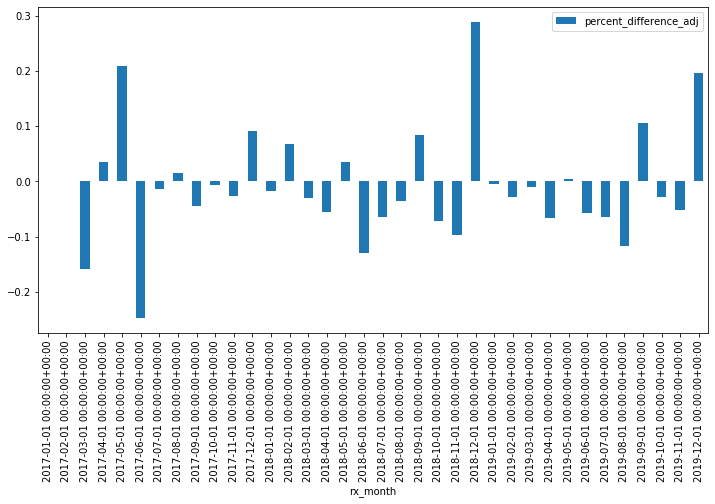

In [32]:
ax = result.plot.bar(figsize = (12,6), x='rx_month', y='percent_difference_adj')

In [33]:
result.head(25)

,rx_month,quantity,rolling_ave_quantity,predicted_cost,predicted_cost_rolling,actual_cost,difference,perc_difference,difference_rolling,perc_difference_rolling,year,mon,bdays0,bdays,bdays2,predicted_cost_adj,difference_adj,percent_difference_adj
0,2017-01-01 00:00:00+00:00,34903814,3.580363e+07,8.151401e+06,8.049272e+06,8.008703e+06,1.426981e+05,0.017818,4.056951e+04,0.005066,2017,1,21,20,NaN,NaN,NaN,NaN
1,2017-02-01 00:00:00+00:00,32129651,3.424974e+07,8.397418e+06,8.104830e+06,7.433894e+06,9.635236e+05,0.129612,6.709353e+05,0.090254,2017,2,19,19,NaN,NaN,NaN,NaN
2,2017-03-01 00:00:00+00:00,35701169,3.324040e+07,8.078590e+06,8.310292e+06,8.723591e+06,-6.450013e+05,-0.073938,-4.132996e+05,-0.047377,2017,3,22,22,20.0,7.344173e+06,-1.379419e+06,-0.158125
3,2017-04-01 00:00:00+00:00,31360938,3.252794e+07,6.176515e+06,6.621021e+06,6.300387e+06,-1.238728e+05,-0.019661,3.206338e+05,0.050891,2017,4,20,18,19.0,6.519654e+06,2.192669e+05,0.034802
4,2017-05-01 00:00:00+00:00,34668969,3.425155e+07,1.361543e+07,1.263800e+07,1.238387e+07,1.231558e+06,0.099449,2.541320e+05,0.020521,2017,5,22,20,22.0,1.497697e+07,2.593101e+06,0.209393
5,2017-06-01 00:00:00+00:00,39153931,3.693957e+07,2.858565e+07,2.993281e+07,3.257050e+07,-3.984846e+06,-0.122345,-2.637690e+06,-0.080984,2017,6,21,21,18.0,2.450199e+07,-8.068511e+06,-0.247725
6,2017-07-01 00:00:00+00:00,44127391,4.466837e+07,3.520778e+07,3.466878e+07,3.570354e+07,-4.957595e+05,-0.013885,-1.034757e+06,-0.028982,2017,7,20,20,20.0,3.520778e+07,-4.957595e+05,-0.013885
7,2017-08-01 00:00:00+00:00,109038306,1.071921e+08,4.732995e+07,4.481809e+07,4.659972e+07,7.302289e+05,0.015670,-1.781633e+06,-0.038233,2017,8,22,21,21.0,4.732995e+07,7.302289e+05,0.015670
8,2017-09-01 00:00:00+00:00,270715011,2.700915e+08,5.839371e+07,5.900726e+07,5.823806e+07,1.556503e+05,0.002673,7.691957e+05,0.013208,2017,9,21,21,20.0,5.561306e+07,-2.625003e+06,-0.045074
9,2017-10-01 00:00:00+00:00,403633528,4.001768e+08,7.105413e+07,7.138988e+07,7.154741e+07,-4.932872e+05,-0.006895,-1.575319e+05,-0.002202,2017,10,21,21,21.0,7.105413e+07,-4.932872e+05,-0.006895


In [34]:
result.describe()

,quantity,rolling_ave_quantity,predicted_cost,predicted_cost_rolling,actual_cost,difference,perc_difference,difference_rolling,perc_difference_rolling,year,mon,bdays0,bdays,bdays2,predicted_cost_adj,difference_adj,percent_difference_adj
count,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,36.000000,3.600000e+01,36.000000,36.000000,36.00000,36.000000,36.000000,34.000000,3.400000e+01,3.400000e+01,34.000000
mean,1.650621e+08,1.652281e+08,2.436808e+07,2.436468e+07,2.460322e+07,-2.351389e+05,-0.006644,-2.385368e+05,-0.006818,2018.000000,6.50000,21.000000,20.333333,20.352941,2.539443e+07,-2.018363e+05,-0.008580
std,1.090658e+08,1.087582e+08,1.554031e+07,1.555434e+07,1.567256e+07,1.027457e+06,0.048385,9.098958e+05,0.038622,0.828079,3.50102,0.956183,1.095445,1.097721,1.570388e+07,2.758378e+06,0.104042
min,3.136094e+07,3.252794e+07,6.176515e+06,6.621021e+06,6.300387e+06,-3.984846e+06,-0.122345,-2.637690e+06,-0.080984,2017.000000,1.00000,19.000000,18.000000,18.000000,6.519654e+06,-8.068511e+06,-0.247725
25%,9.745254e+07,9.699663e+07,1.329558e+07,1.272012e+07,1.307452e+07,-5.769702e+05,-0.031024,-7.889908e+05,-0.038682,2017.000000,3.75000,20.000000,19.750000,20.000000,1.472777e+07,-1.337229e+06,-0.062244
50%,1.341943e+08,1.349755e+08,1.814484e+07,1.788253e+07,1.858640e+07,-2.599070e+05,-0.011448,-2.841992e+05,-0.012100,2018.000000,6.50000,21.000000,21.000000,21.000000,1.928529e+07,-5.336296e+05,-0.026933
75%,2.313135e+08,2.348814e+08,3.329990e+07,3.355665e+07,3.367090e+07,2.387476e+05,0.018082,2.707575e+05,0.015036,2019.000000,9.25000,22.000000,21.000000,21.000000,3.286069e+07,4.849511e+05,0.030019
max,4.153256e+08,4.103918e+08,7.105413e+07,7.138988e+07,7.154741e+07,1.958660e+06,0.129612,2.543399e+06,0.090254,2019.000000,12.00000,22.000000,22.000000,22.000000,7.105413e+07,1.038908e+07,0.288760


In [35]:
result['perc_difference'].mean()

-0.006644258757209033